In [1]:
!pip3 install tensorflow pandas numpy matplotlib sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import deque
import time
import os
import numpy as np
import pandas as pd
import random

In [3]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [4]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [5]:
# Window size or the sequence length
N_STEPS = 100
# Lookup step, 1 is the next day
LOOKUP_STEP = 15
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 16
EPOCHS = 30
# TSLA stock market
ticker = "Bitcoin"
ticker_data_filename = "all_data.csv"
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [6]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/GE2340_AI/all_data.csv')

data = {}
column_scaler = {}
data['df'] = df.copy()
feature_columns=['Volume', 'Open', 'High', 'Low', 'Close']
df['future'] = df['Close'].shift(-LOOKUP_STEP)
df.to_csv("rawdf.csv")

Mounted at /content/gdrive


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/GE2340_AI/all_data.csv')


data = {}
column_scaler = {}
data['df'] = df.copy()
feature_columns=['Volume', 'Open', 'High', 'Low', 'Close']
for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
data["column_scaler"] = column_scaler
df['future'] = df['Close'].shift(-LOOKUP_STEP)
df.to_csv("rawdf.csv")

last_sequence = np.array(df[feature_columns].tail(LOOKUP_STEP))
df.dropna(inplace=True)
sequence_data = []
sequences = deque(maxlen=N_STEPS)
for entry, target in zip(df[feature_columns + ["Time"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])
last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
last_sequence = np.array(last_sequence).astype(np.float32)
# add to result
data['last_sequence'] = last_sequence
# construct the X's and y's
X, y = [], []
for seq, target in sequence_data:
    X.append(seq)
    y.append(target)
# convert to numpy arrays
X = np.array(X)
y = np.array(y)

data["X_train"], data["X_test"], data["y_train"], data["y_test"] = train_test_split(X, y,
                                                                                test_size=TEST_SIZE)
 # get the list of test set dates
dates = data["X_test"][:, -1, -1]
data["df"].index = pd.to_datetime(data["df"]['Time'])
# drop The original date column
data["df"] = data["df"].drop(['Time'], axis='columns')
# retrieve test features from the original dataframe
data["test_df"] = data["df"].loc[dates]
# remove duplicated dates in the testing dataframe
data["test_df"] = data["test_df"][~data["test_df"].index.duplicated(keep='first')]
# remove dates from the training/testing sets & convert to float32
data["X_train"] = data["X_train"][:, :, :len(feature_columns)].astype(np.float32)
data["X_test"] = data["X_test"][:, :, :len(feature_columns)].astype(np.float32)
data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


{'df':                 Open      High       Low     Close        Volume
 Time                                                            
 2017-08-17   4261.48   4485.39   4200.74   4285.08    795.150377
 2017-08-18   4285.08   4371.52   3938.77   4108.37   1199.888264
 2017-08-19   4108.37   4184.69   3850.00   4139.98    381.309763
 2017-08-20   4120.98   4211.08   4032.62   4086.29    467.083022
 2017-08-21   4069.13   4119.62   3911.79   4016.00    691.743060
 ...              ...       ...       ...       ...           ...
 2023-11-25  37713.57  37888.00  37591.10  37780.67  11396.144640
 2023-11-26  37780.67  37814.63  37150.00  37447.43  21264.537230
 2023-11-27  37447.42  37569.23  36707.00  37242.70  30001.073760
 2023-11-28  37242.70  38377.00  36868.41  37818.87  37544.466670
 2023-11-29  37818.88  38093.72  37677.96  37909.34   4980.849490
 
 [2296 rows x 5 columns],
 'column_scaler': {'Volume': MinMaxScaler(),
  'Open': MinMaxScaler(),
  'High': MinMaxScaler(),
  'Low': Mi

In [9]:
model = create_model(N_STEPS, len(feature_columns), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join(model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=30,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0597
Epoch 1: val_loss improved from inf to 0.00251, saving model to 2023-12-03_Bitcoin-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-100-step-15-layers-2-units-256.h5
110/110 [==============================] - 74s 621ms/step - loss: 0.0050 - mean_absolute_error: 0.0597 - val_loss: 0.0025 - val_mean_absolute_error: 0.0442
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0519
Epoch 2: val_loss did not improve from 0.00251
110/110 [==============================] - 66s 602ms/step - loss: 0.0030 - mean_absolute_error: 0.0519 - val_loss: 0.0026 - val_mean_absolute_error: 0.0486
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0489
Epoch 3: val_loss did not improve from 0.00251
110/110 [==============================] - 68s 624ms/step - loss: 0.0027 - mean_absolute_error: 0.0489 - val_loss: 

In [10]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_close_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'Close_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [11]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to
    construct a final dataframe that includes the features along
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current,
    # then calculate the true future price minus the current price, to get the buy profit
    # default 1 stock for cal profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["Close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["Close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"Close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit,
                                    final_df["Close"],
                                    final_df[f"Close_{LOOKUP_STEP}"],
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit,
                                    final_df["Close"],
                                    final_df[f"Close_{LOOKUP_STEP}"],
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [12]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["Close"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [13]:
# load optimal model weights from results folder
model_path = os.path.join(model_name) + ".h5"
model.load_weights(model_path)
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["Close"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [14]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

14/14 [==============================] - 3s 185ms/step


In [15]:
# predict the future price
future_price = predict(model, data)

1/1 [==============================] - 0s 105ms/step


In [16]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [17]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 38888.86$
huber_loss loss: 0.0021425876766443253
Mean Absolute Error: 5894.175081777424
Accuracy score: 0.5354691075514875
Total buy profit: 93134.33000000002
Total sell profit: -4426.829999999991
Total profit: 88707.50000000003
Profit per trade: 202.991990846682


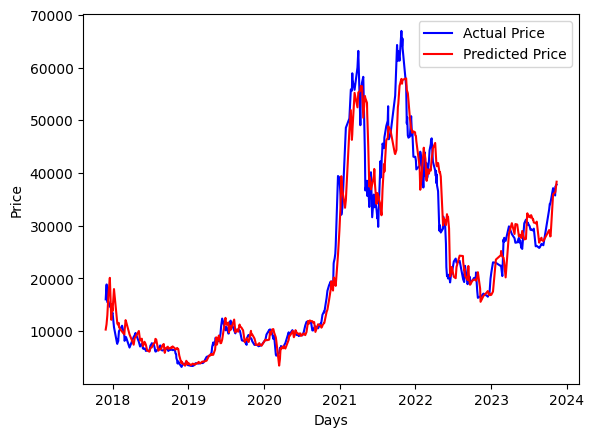

In [18]:
# plot true/pred prices graph
plot_graph(final_df)

In [19]:
print(final_df.tail(10))
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)
data['df'].to_csv("data.csv")

                Open      High       Low     Close       Volume      Close_15  \
Time                                                                            
2023-09-02  25805.04  25987.50  25752.47  25869.51  16250.77698  27305.644531   
2023-09-10  25901.60  26033.66  25570.57  25841.61  18738.26914  27103.720703   
2023-10-08  27956.67  28095.14  27687.50  27917.05  19693.56921  29176.339844   
2023-10-11  27390.12  27477.39  26538.66  26875.52  37349.44706  28561.072266   
2023-10-13  26759.63  27130.00  26685.00  26862.00  24115.76499  27972.144531   
2023-10-15  26852.48  27293.33  26808.25  27154.15  15274.69170  28013.107422   
2023-10-27  34151.66  34245.00  33390.95  33892.02  32330.40106  35969.472656   
2023-11-06  35011.89  35276.33  34725.90  35046.09  22346.47086  36334.070312   
2023-11-07  35046.09  35888.00  34523.06  35399.12  38688.73692  36412.667969   
2023-11-13  37064.13  37417.99  36333.00  36462.93  32798.18252  38352.007812   

            true_close_15  